In [1]:
import subprocess
import sys

In [2]:
# Define the command
command = ['python', 'run_program.py', 'inputdata/1616.jpg', 'detail', '404']

# Run the command and capture output
process = subprocess.Popen(
    command,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    universal_newlines=True
)

# Get the output
stdout, stderr = process.communicate()

# Print the output
print("Standard Output:")
print(stdout)

if stderr:
    print("\nStandard Error:")
    print(stderr)

Standard Output:

Converting image...
Input JPG: d:\Project\sc_cuda2\inputdata\1616.jpg
Temp PPM: d:\Project\sc_cuda2\temp\temp_input.pnm
Successfully converted d:\Project\sc_cuda2\inputdata\1616.jpg to d:\Project\sc_cuda2\temp\temp_input.pnm
File exists: True
File size: 18817775 bytes

Processing seq implementation...
Running command: .\seam_carving_seq.exe d:\Project\sc_cuda2\temp\temp_input.pnm d:\Project\sc_cuda2\temp\detail.pnm 404
Output:
Image size (width x height): 1616 x 909

Number of seam removed: 404


Seam Carving Performance Analysis:
---------------------------------
Grayscale conversion: 2.23 ms
Backward energy (Sobel): 8824.58 ms
Forward energy: 6316.98 ms
Hybrid energy: 1236.24 ms
Dynamic programming: 502.18 ms
Seam tracing and removal: 516.93 ms
---------------------------------
Total seam carving time: 26586.39 ms

Image size after seam carving (new_width x height): 1212 x 909



Processing omp implementation...
Running command: .\seam_carving_omp.exe d:\Project\sc_

In [3]:
# This cell should be run after the command completes
# It will parse the output and extract the performance metrics
import re

def extract_metrics(output):
    metrics = {}
    current_impl = None
    
    for line in output.split('\n'):
        if 'Processing' in line and 'implementation' in line:
            current_impl = line.split('Processing ')[1].split(' implementation')[0]
            metrics[current_impl] = {}
        elif current_impl and 'Grayscale conversion:' in line:
            metrics[current_impl]['Grayscale conversion'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Backward energy (Sobel):' in line:
            metrics[current_impl]['Backward energy (Sobel)'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Forward energy:' in line:
            metrics[current_impl]['Forward energy'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Hybrid energy:' in line:
            metrics[current_impl]['Hybrid energy'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Dynamic programming:' in line:
            metrics[current_impl]['Dynamic programming'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Seam tracing and removal:' in line:
            metrics[current_impl]['Seam tracing and removal'] = float(line.split(':')[1].strip().split()[0])
        elif current_impl and 'Total seam carving time:' in line:
            metrics[current_impl]['Total time'] = float(line.split(':')[1].strip().split()[0])
    
    return metrics

# Parse the metrics from the output
performance_data = extract_metrics(stdout)
print("Extracted Performance Metrics:")
print(performance_data)

Extracted Performance Metrics:
{'seq': {'Grayscale conversion': 2.23, 'Backward energy (Sobel)': 8824.58, 'Forward energy': 6316.98, 'Hybrid energy': 1236.24, 'Dynamic programming': 502.18, 'Seam tracing and removal': 516.93, 'Total time': 26586.39}, 'omp': {'Grayscale conversion': 1.12, 'Backward energy (Sobel)': 1497.15, 'Forward energy': 1747.8, 'Hybrid energy': 270.04, 'Dynamic programming': 953.47, 'Seam tracing and removal': 966.32, 'Total time': 8121.13}, 'cuda': {'Grayscale conversion': 0.53, 'Backward energy (Sobel)': 86.88, 'Forward energy': 91.23, 'Hybrid energy': 129.55, 'Dynamic programming': 374.51, 'Seam tracing and removal': 1199.88, 'Total time': 1955.06}, 'mpi': {'Grayscale conversion': 2.87, 'Backward energy (Sobel)': 1282.52, 'Forward energy': 939.72, 'Hybrid energy': 234.78, 'Dynamic programming': 919.88, 'Seam tracing and removal': 10431.39, 'Total time': 19261.35}}


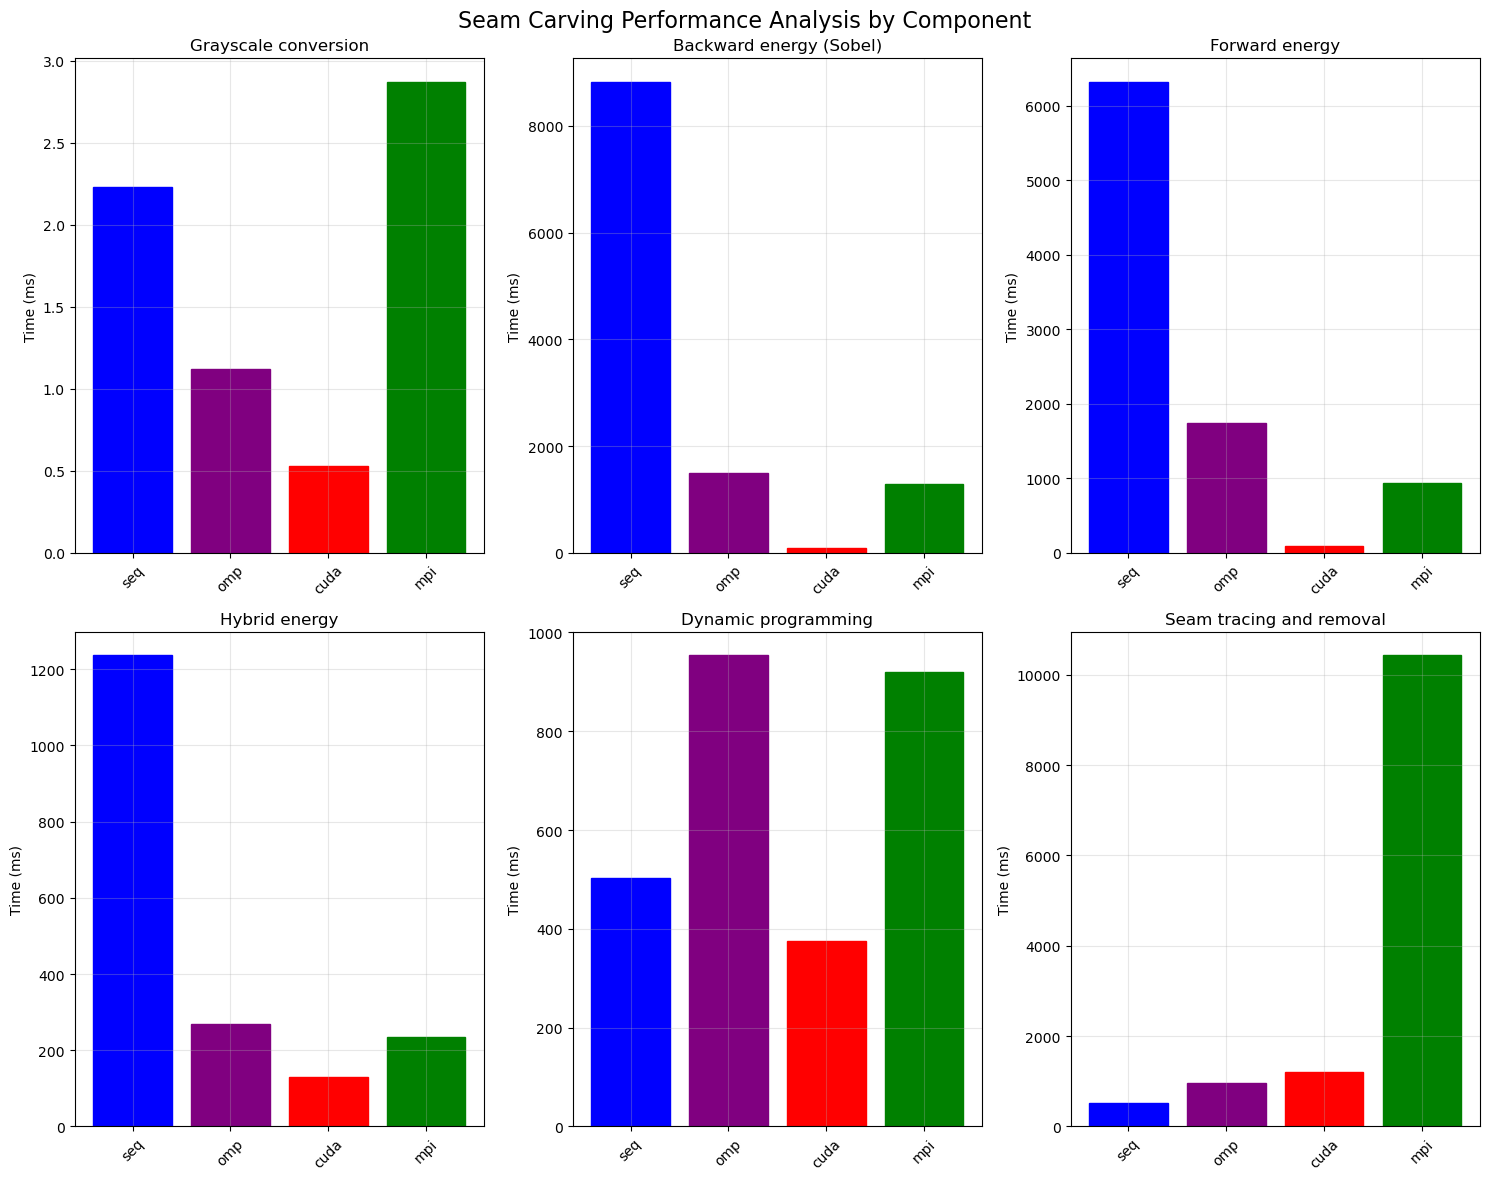

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define colors for each implementation
colors = {
    'sequential': 'blue',
    'omp': 'purple', 
    'cuda': 'red',
    'mpi': 'green'
}

# Convert to DataFrame
df = pd.DataFrame(performance_data)

# Remove 'Total time' for individual component analysis
components = df.index[:-1]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Seam Carving Performance Analysis by Component', fontsize=16)

# Plot for each component
for i, (component, ax) in enumerate(zip(components, axes.flat)):
    bars = ax.bar(df.columns, df.loc[component])
    # Set color for each bar based on implementation
    for bar, impl in zip(bars, df.columns):
        # Map implementation name to color
        if impl == 'seq':
            bar.set_color(colors['sequential'])
        else:
            bar.set_color(colors[impl])
    ax.set_title(f'{component}')
    ax.set_ylabel('Time (ms)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Remove empty subplot if any
if len(components) < len(axes.flat):
    fig.delaxes(axes.flat[-1])

plt.tight_layout()
plt.show()

In [5]:
print(pd.DataFrame(performance_data).round(2).to_markdown())

|                          |      seq |     omp |    cuda |      mpi |
|:-------------------------|---------:|--------:|--------:|---------:|
| Grayscale conversion     |     2.23 |    1.12 |    0.53 |     2.87 |
| Backward energy (Sobel)  |  8824.58 | 1497.15 |   86.88 |  1282.52 |
| Forward energy           |  6316.98 | 1747.8  |   91.23 |   939.72 |
| Hybrid energy            |  1236.24 |  270.04 |  129.55 |   234.78 |
| Dynamic programming      |   502.18 |  953.47 |  374.51 |   919.88 |
| Seam tracing and removal |   516.93 |  966.32 | 1199.88 | 10431.4  |
| Total time               | 26586.4  | 8121.13 | 1955.06 | 19261.3  |


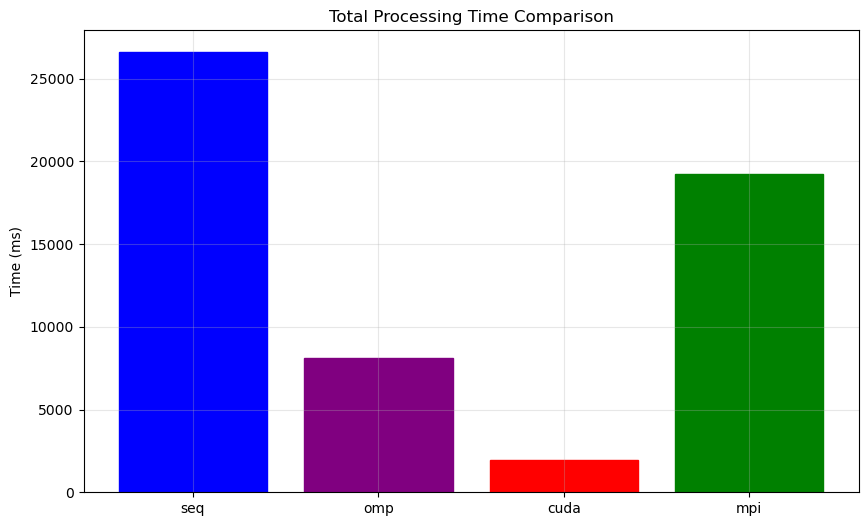

In [6]:
# Plot total times comparison
plt.figure(figsize=(10, 6))
total_times = [df[impl]['Total time'] for impl in df.columns]
bars = plt.bar(df.columns, total_times)
# Set color for each bar based on implementation
for bar, impl in zip(bars, df.columns):
    # Map implementation name to color
    if impl == 'seq':
        bar.set_color(colors['sequential'])
    else:
        bar.set_color(colors[impl])
plt.title('Total Processing Time Comparison')
plt.ylabel('Time (ms)')
plt.grid(True, alpha=0.3)
plt.show()

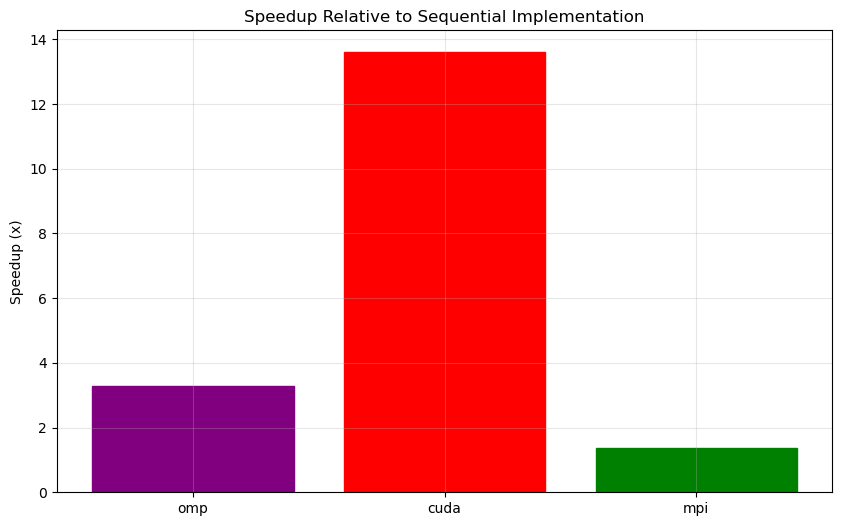

In [7]:
# Calculate speedup relative to sequential implementation
sequential_time = df['seq']['Total time']
speedup = {
    impl: sequential_time / df[impl]['Total time']
    for impl in df.columns
    if impl != 'seq'
}

plt.figure(figsize=(10, 6))
bars = plt.bar(speedup.keys(), speedup.values())
# Set color for each bar based on implementation
for bar, impl in zip(bars, speedup.keys()):
    bar.set_color(colors[impl])
plt.title('Speedup Relative to Sequential Implementation')
plt.ylabel('Speedup (x)')
plt.grid(True, alpha=0.3)
plt.show()

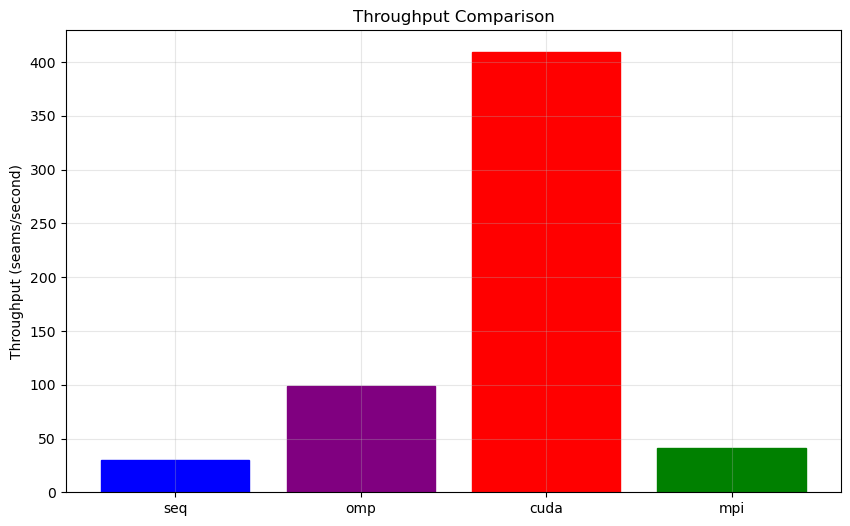

In [8]:
# Define throughput calculation function
def calculate_throughput(num_seams, time_ms):
    """Calculate throughput in seams/second"""
    return (num_seams / time_ms) * 1000  # Convert ms to seconds

# Plot throughput comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(df.columns, [calculate_throughput(800, df[impl]['Total time']) for impl in df.columns])

# Set color for each bar based on implementation
for bar, impl in zip(bars, df.columns):
    if impl == 'seq':
        bar.set_color(colors['sequential'])
    else:
        bar.set_color(colors[impl])

plt.title('Throughput Comparison')
plt.ylabel('Throughput (seams/second)')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Create a comprehensive performance metrics table
performance_table = pd.DataFrame({
    'Implementation': list(df.columns),
    'Total Time (ms)': [df[impl]['Total time'] for impl in df.columns],
    'Throughput (seams/s)': [calculate_throughput(800, df[impl]['Total time']) for impl in df.columns],
    'Speedup': [1.0] + [sequential_time / df[impl]['Total time'] for impl in df.columns if impl != 'seq']
})

# Format the table for better readability
performance_table['Total Time (ms)'] = performance_table['Total Time (ms)'].round(2)
performance_table['Throughput (seams/s)'] = performance_table['Throughput (seams/s)'].round(2)
performance_table['Speedup'] = performance_table['Speedup'].round(2)

print("\nComprehensive Performance Metrics:")
print(performance_table.to_string(index=False))


Comprehensive Performance Metrics:
Implementation  Total Time (ms)  Throughput (seams/s)  Speedup
           seq         26586.39                 30.09     1.00
           omp          8121.13                 98.51     3.27
          cuda          1955.06                409.19    13.60
           mpi         19261.35                 41.53     1.38


In [10]:
!pip install opencv-python

In [11]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os
from tabulate import tabulate

In [12]:
def calculate_mse(img1, img2):
    diff = (img1.astype(float) - img2.astype(float)) / 255.0  
    squared_diff = np.clip(diff ** 2, 0, 1.0)  
    return np.mean(squared_diff) + 1e-6  

def calculate_psnr(img1, img2):
    mse = calculate_mse(img1, img2)
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / (np.sqrt(mse) + 1e-6))

def calculate_metrics(reference_img, comparison_img):
    # Convert images to grayscale if they're not already
    if len(reference_img.shape) == 3:
        # Use a more forgiving color conversion
        reference_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY).astype(float) / 255
        comparison_gray = cv2.cvtColor(comparison_img, cv2.COLOR_BGR2GRAY).astype(float) / 255
    else:
        reference_gray = reference_img.astype(float) / 255
        comparison_gray = comparison_img.astype(float) / 255
    
    # Calculate metrics with normalized values
    mse_value = calculate_mse(reference_gray, comparison_gray)
    psnr_value = calculate_psnr(reference_gray, comparison_gray)
    # Use more lenient SSIM parameters
    ssim_value = ssim(reference_gray, comparison_gray, data_range=1.0, gaussian_weights=True, sigma=5, use_sample_covariance=False, win_size=21)
    
    return mse_value, psnr_value, ssim_value

In [13]:
# Define the methods to compare
methods = ['cuda', 'mpi', 'omp', 'seq']

# Load reference image 
# reference_path = 'inputdata/1616.jpg'
reference_path = 'output/detail_seq.jpg'
reference_img = cv2.imread(reference_path)

if reference_img is None:
    print(f"Warning: Could not load reference image from {reference_path}")
    reference_img = np.zeros((100,100,3), dtype=np.uint8) 

# Initialize results storage
results = []

# Compare each method with the reference
for method in methods:
    comparison_path = f'output/detail_{method}.jpg'
    comparison_img = cv2.imread(comparison_path)
    
    if comparison_img is None:
        print(f"Warning: Could not load image for method {method}, skipping...")
        # Add placeholder results
        results.append([
            method,
            "N/A",
            "N/A",
            "N/A"
        ])
        continue
    
    # Ensure images have the same size
    if reference_img.shape != comparison_img.shape:
        comparison_img = cv2.resize(comparison_img, (reference_img.shape[1], reference_img.shape[0]))
    
    try:
        # Calculate metrics with error handling
        mse_value, psnr_value, ssim_value = calculate_metrics(reference_img, comparison_img)
    except Exception as e:
        print(f"Warning: Error calculating metrics for {method}: {e}")
        mse_value, psnr_value, ssim_value = 0.0, 0.0, 0.0
    
    # Store results
    results.append([
        method,
        f"{mse_value:.4f}", 
        f"{ssim_value:.4f}",
        f"{psnr_value:.4f}"
    ])

# Display results in a table
headers = [
    "Method", 
    "MSE", 
    "SSIM", 
    "PSNR"
    ]
print("\nImage Quality Metrics:")
print(tabulate(results, headers=headers, tablefmt="grid"))


Image Quality Metrics:
+----------+-------+--------+---------+
| Method   |   MSE |   SSIM |    PSNR |
+==========+=======+========+=========+
| cuda     |     0 |  0.949 | 108.062 |
+----------+-------+--------+---------+
| mpi      |     0 |  1     | 108.122 |
+----------+-------+--------+---------+
| omp      |     0 |  1     | 108.122 |
+----------+-------+--------+---------+
| seq      |     0 |  1     | 108.122 |
+----------+-------+--------+---------+


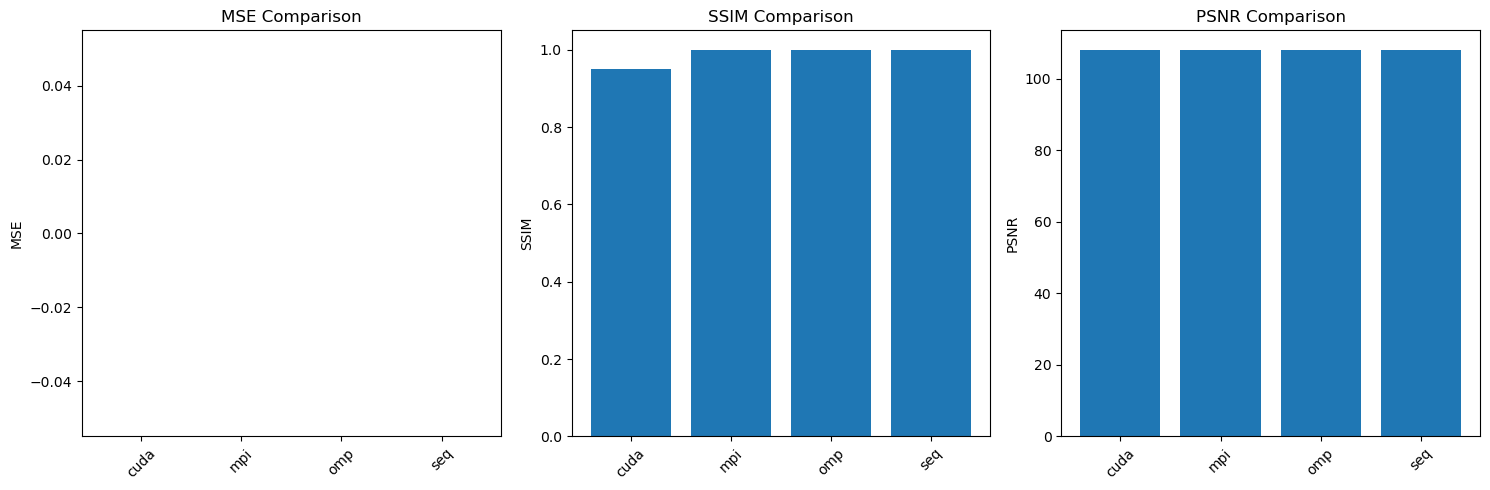

In [15]:
metrics = ['MSE', 'SSIM', 'PSNR']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, metric in enumerate(metrics):
    values = [float(row[idx + 1]) for row in results]
    methods_without_seq = [row[0] for row in results]
    
    axes[idx].bar(methods_without_seq, values)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()